# Documentation

How to use the mlp-framework and ddqn-framework. This notebook gives a short overview of the basic usage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import gym
import time 

## Introduction  
What are the frameworks doing and what kind of abstraction to deal with.

### mlp-framework

To use the framework the hightest abstraction level to think of is the layer-object. Each layer-object is defined by it's number of inputs and neurons. Activation, regularization and momentum-learning paramesters are idependant of other layers and can be set idividually. So you could have a tanh activation in the first layer and then a ReLu in the second before i.e. classifying with a logistic function.

In [125]:
###################### MLP FRAMEWORK - Basics
###################### 
######################

import mlp_framework as nn

### there are default settings, so this is the minimal code
### required to build a 5 layer neural network classifier

# initializing each layer with input and output size 
# (keep in mind: this just an example and a really stupid model to do the job)
A1 = nn.layer(2,64)
A2 = nn.layer(64,48)
A3 = nn.layer(48,32)
A4 = nn.layer(32,20)
AOUT = nn.layer(20,3)
# set the output layer activation to 'logistic transfer function' [0,1] 
AOUT.f = nn.f_lgtr
# pass list of layer to mlp model class 
model = nn.mlp([A1,A2,A3,A4,AOUT])

#setting parameters for all layers
for L in model.Layerlist:
    L.eta = 1e-2
    #L.reg = 'RMSProp'   #setting regularizer

#### This is everything needed to build a model and set model parameters 
#### also take look in the help() (i.e. help(nn.layer),help(nn.mlp))

# for prediction call the model inference method with data
#prediction = model.infer(Data)    

#### 2D example

##### generate toy data

In [ ]:
### some toy data and meshgrid for plots 

D = np.random.multivariate_normal([-1,-1],np.diag([.4,.3]),size=100)
D_ = np.random.multivariate_normal([0,0,],np.diag([.2,.4]),size=100)
D__ = np.random.multivariate_normal([-1,1,],np.diag([.1,.5]),size=100)
Data = np.concatenate((D,D_,D__),0) ### Data
T = np.ones(Data.shape[0])
T[:100] *= 0
T[200:300] *= 2
targets = nn.one_hot(T[:,True].T) ### targets

## visu mesh grid
R = np.linspace(-2, 2, 100, endpoint=True) 
A,B = np.meshgrid(R,R)
G = [] 
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        G += [[A[i][i],A[i][j]]]
G = np.array(G)

##### train the model

step: 1000 loss: 0.251420296244
step: 2000 loss: 0.211307811016
step: 3000 loss: 0.180628240518
step: 4000 loss: 0.102143747421
step: 5000 loss: 0.0889219522264


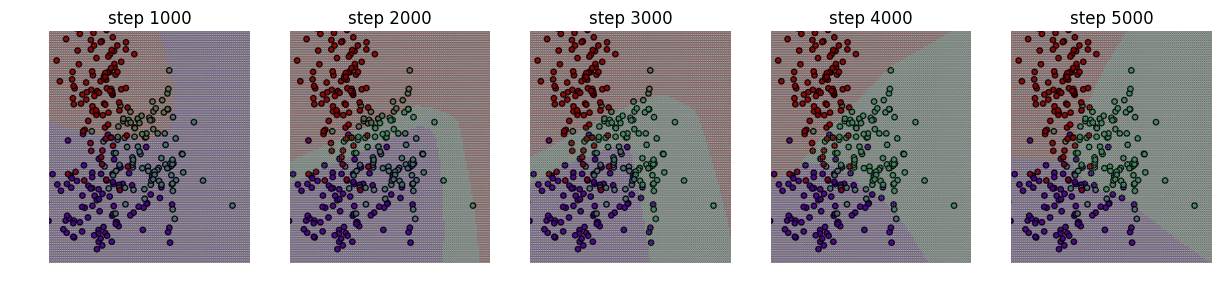

In [126]:
##################  TRAINING and PREICTION  ##################

# train the model with data and targets
iterations = 5000
predictions = []
for i in range(iterations):
    model.train(Data,targets) # THIS TRAINS FOR 1 STEP, rows are samples and columns are features
    if (i+1)%1000 == 0: 
        print('step:',i+1,'loss:',model.loss)
        predictions += [model.infer(G)] 

# plotting 
plt.figure(figsize=(15,3))
predictions = np.array(predictions)
for i in range(predictions.shape[0]):
    plt.subplot(1,5,i+1)
    plt.scatter(Data[:,0],Data[:,1],c=T,cmap='rainbow',s=15,alpha=.9)
    plt.title('step {}'.format((i+1)*1000))
    plt.scatter(G[:,0],G[:,1],c=np.argmax(predictions[i],axis=1)*255,edgecolors=None,s=1,cmap='rainbow',alpha=.4)
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.axis('off')

plt.show()

### ddqn-framework  
This framework is for training Double-DQN models on [OpenAI Gym games](https://gym.openai.com/envs/). 
Pass the targetDQN and onlineDQN together with a configuration to create a learning environment.  
  
There are some useful tools in there if you want to tinker around. i.e. a numpy replaybuffer



In [ ]:
import ddqn_framework as ddqn
import mlp_framework as nn
# STEP 1: create configuration
configuration = ddqn.trainer_config(game_name='Acrobot-v1',
                                BUFFER_SIZE = 50e3,
                                STEPS_PER_EPISODE = 500,
                                MAX_STEPS = 100000,   
                                UPDATE_TARGET_STEPS = 1000,
                                BATCH_SIZE = 32,
                                GAMMA = 0.99,
                                EXPLORATION = 100,
                                E_MIN = 0.01                                    
                                )#game_name='CartPole-v0', game_name='LunarLander-v2'

# STEP 2: build models (online & target)
A1 = nn.layer(configuration.INPUT_SIZE,256)
A2 = nn.layer(256,256)
AOUT = nn.layer(256,configuration.OUTPUT_SIZE)
AOUT.f = nn.f_iden

L1 = nn.layer(configuration.INPUT_SIZE,256)
L2 = nn.layer(256,256)
LOUT = nn.layer(256,configuration.OUTPUT_SIZE)
LOUT.f = nn.f_iden
onlineNet = nn.mlp([A1,A2,AOUT])
targetNet = nn.mlp([L1,L2,LOUT])

# STEP 3: create trainer
dqn_model = ddqn.trainer(onlineNet,targetNet,configuration)

# STEP 5: train the trainer (dqn_model) for configuration.MAX_STEPS:
dqn_model.train(log=True)
print('training done')
# OR: train the trainer (dqn_model) for one episode(!) by setting 'flag' = True :
dqn_model.train(flag=True)

#  STEP 6: 
# get your models, config and logs from the trainer (see 'some useful stuff')

#################### some usefull stuff:
### save config
#first_config = dqn_model.save_config()
### use new config ('new_config')
#dqn_model.load_config(new_config)
### apply/get  model
#dqn_model.onlineNet = new_onlineNet
#trained_targetNet  = dqn_model.targetNet
### clear REPLAY BUFFER
#dqn_model.REPLAY_BUFFER = DDQN.ringbuffer(dqn_model.BUFFER_SIZE)
### get reward / loss logs
#loss_list = dqn_model.loss_plot
#reward_list = dqn_model.reward_plot

#### Plotting results

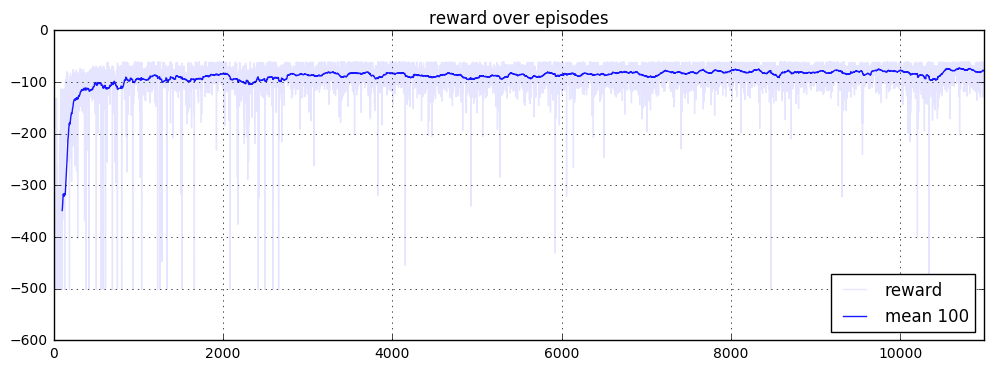

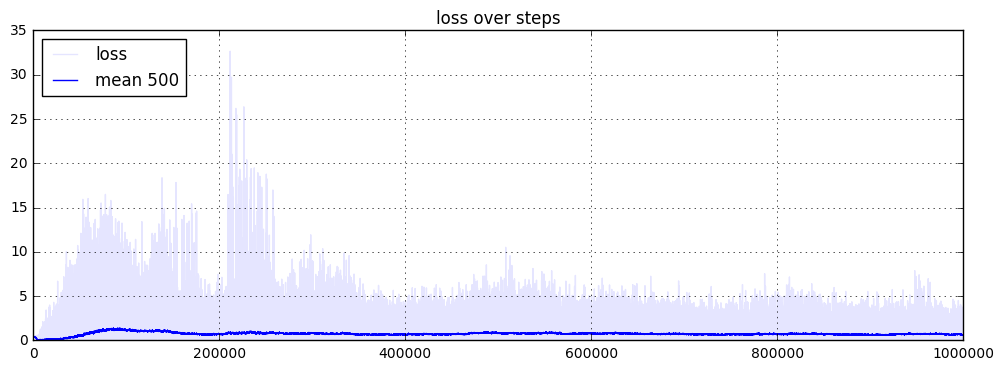

In [117]:
reward_plot = np.array(dqn_model.reward_plot) 
loss_plot = np.array(dqn_model.loss_plot)     
rewdata = pd.Series(reward_plot)
lossdata = pd.Series(loss_plot)

plt.figure(figsize=(12,4))
rewdata.plot(alpha=0.1,color='b',label='reward')
rewdata.rolling(window=100).mean().plot(style='b',alpha=.9,label='mean 100')
plt.legend(loc='lower right')
plt.grid()
plt.title('reward over episodes')

plt.figure(figsize=(12,4))
lossdata.plot(alpha=0.1,color='b',label='loss')
lossdata.rolling(window=500).mean().plot(style='b',label='mean 500')
#plt.ylim(0,40)
plt.legend(loc='upper left')
plt.title('loss over steps')
plt.grid()
plt.show()

#### Play some games
Should pop-up a window to let the agent(DDQN) play a few games. Waits 3sec after each episode.

In [ ]:
envX = gym.make(configuration.game_name).env#('MountainCar-v0')#('Alien-v0')#('LunarLander-v2')
for i_episode in range(20):  ## number of games to be played
    observation = envX.reset()
    rew = 0.
    for t in range(configuration.STEPS_PER_EPISODE):
        envX.render()
        action = np.argmax(dqn_model.targetNet.infer(observation[True,:]))
        observation, reward, done, info = envX.step(action)
        rew += reward
        if done or (t+1) >= configuration.STEPS_PER_EPISODE:
            print("Episode finished after {} timesteps with reward {}".format(t+1,rew))
            time.sleep(3)
            break

## save and load models

In [28]:
import pickle as pkl

#save model
pkl.dump(dqn_model,open("dqn_model.p","wb")) # ~50 MB with full replaybuffer(50k) + loss/reward logs (1e6 steps)
#load model
loaded_model = pkl.load(open("dqn_model.p","rb"))

#continue training model 
loaded_model.MAX_STEPS = 5000
loaded_model.train(log=True)

## Experimental  
Testing out the experimental features of mlp_framework

### Dense-DDQN  
Stealing ideas from [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993) and using
dense connections for MLPs somehow stabilizes the training. However, since the number of inputs for each layer(except the first) increase, 
further tests in different games and with approx. the same amount of connections have to be done, to exclude that the stabilizing effect is not solely due to more connections.  
  
Dense connections between layers are similar to [residual networks](https://arxiv.org/abs/1512.03385), but instead of adding the identity, 
each layer has the concatenated outputs of all previous layers as inputs. This helps with a lot of stuff, since earlier layers also see the gradients from later ones. Some kind of deep supervision.  
Observations over classification tasks show faster convergence (- I think mostly due to the more frequent gradient updates), 
regularization effects, like smoother decision boundaries, and the ability to train much deeper networks than is normaly 
the case with MLPs ...or at least more stable training.

In [ ]:
import ddqn_framework as ddqn
import mlp_framework as nn

configuration = ddqn.trainer_config(game_name='Acrobot-v1',
                                BUFFER_SIZE = 50e3,
                                STEPS_PER_EPISODE = 500,
                                MAX_STEPS = 100000,  # MAX_STEPS=100k 
                                UPDATE_TARGET_STEPS = 1000,
                                BATCH_SIZE = 32,
                                GAMMA = 0.99,
                                EXPLORATION = 100,
                                E_MIN = 0.01                                    
                                )#game_name='CartPole-v0', game_name='LunarLander-v2'

INPUT_SIZE = configuration.INPUT_SIZE
OUTPUT_SIZE = configuration.OUTPUT_SIZE
growth = 256
L1 = nn.layer(INPUT_SIZE,growth)
L2 = nn.layer(INPUT_SIZE+1*growth,growth)
#L3 = nn.layer(INPUT_SIZE+2*growth,growth)
LOUT = nn.layer(INPUT_SIZE+(2*growth),OUTPUT_SIZE)
LOUT.f = nn.f_iden
A1 = nn.layer(INPUT_SIZE,growth)
A2 = nn.layer(INPUT_SIZE+1*growth,growth)
#A3 = nn.layer(INPUT_SIZE+2*growth,growth)
AOUT = nn.layer(INPUT_SIZE+(2*growth),OUTPUT_SIZE)
AOUT.f = nn.f_iden
onlineNet = nn.dense_mlp([A1,A2,AOUT])
targetNet = nn.dense_mlp([L1,L2,LOUT])


dense_model = ddqn.trainer(onlineNet,targetNet,configuration)
dense_model.train(log=True)
print('training done')

#### Plotting results  
Both models, the standard DDQN(dqn_model) and the Dense-DDQN(dense_model), consist of 3 layers with 256 neurons in the hiddenlayers.  
They are trained for 1,000,000 steps. This might take some time, so try with MAX_STEPS=100,000 first (which should be enough).

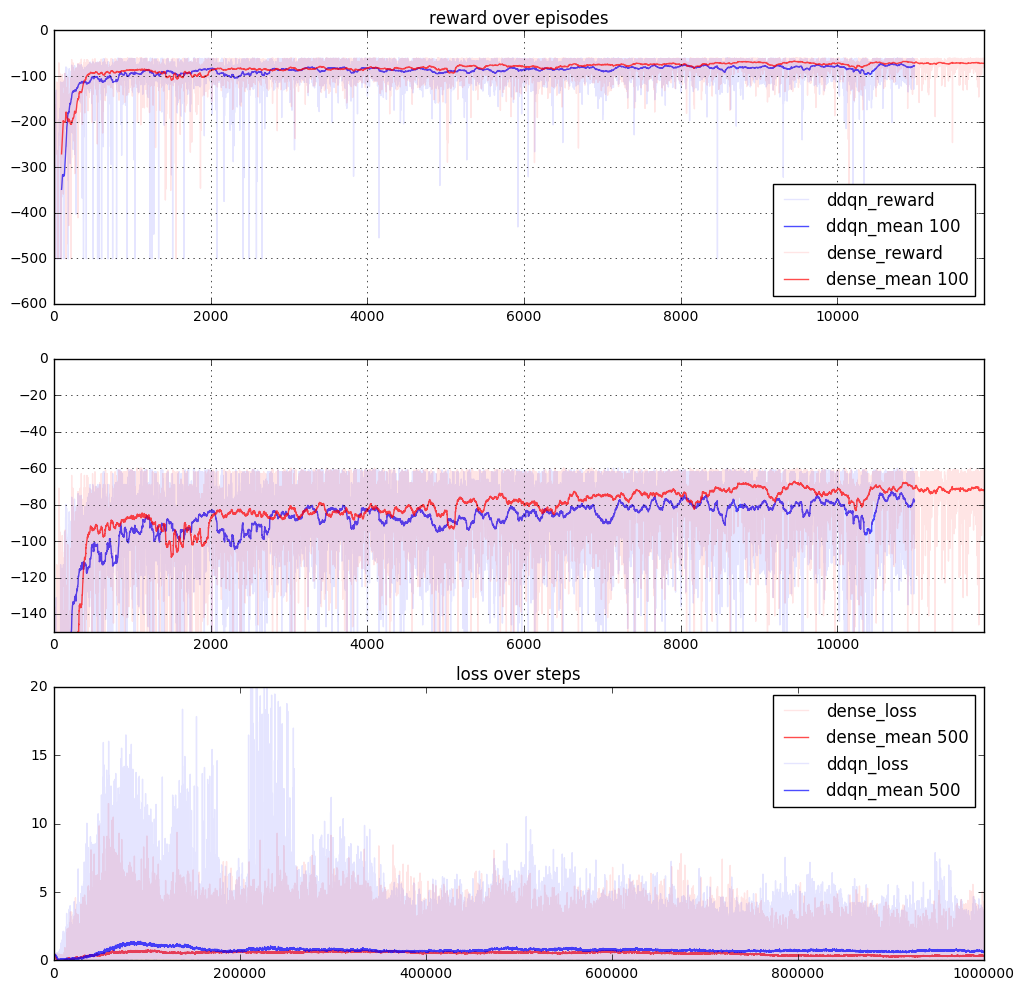

In [122]:
dense_reward_plot = np.array(dense_model.reward_plot)
dense_loss_plot = np.array(dense_model.loss_plot)
dqn_reward_plot = np.array(dqn_model.reward_plot)
dqn_loss_plot = np.array(dqn_model.loss_plot)

dense_rewdata = pd.Series(dense_reward_plot)
dense_lossdata = pd.Series(dense_loss_plot)
dqn_rewdata = pd.Series(dqn_reward_plot)
dqn_lossdata = pd.Series(dqn_loss_plot)

plt.figure(figsize=(12,12))
plt.subplot(311)
dqn_rewdata.plot(alpha=0.1,color='b',label='ddqn_reward')
dqn_rewdata.rolling(window=100).mean().plot(color='b',alpha=.7,label='ddqn_mean 100')
dense_rewdata.plot(alpha=0.1,color='r',label='dense_reward')
dense_rewdata.rolling(window=100).mean().plot(color='r',alpha=.7,label='dense_mean 100')
plt.legend(loc='lower right')
plt.grid()
plt.title('reward over episodes')

plt.subplot(312)
dqn_rewdata.plot(alpha=0.1,color='b',label='ddqn_reward')
dqn_rewdata.rolling(window=100).mean().plot(color='b',alpha=.7,label='ddqn_mean 100')
dense_rewdata.plot(alpha=0.1,color='r',label='dense_reward')
dense_rewdata.rolling(window=100).mean().plot(color='r',alpha=.7,label='dense_mean 100')
plt.ylim(-150,0)
plt.grid()

plt.subplot(313)
dense_lossdata.plot(alpha=0.1,color='r',label='dense_loss')
dense_lossdata.rolling(window=500).mean().plot(style='r',label='dense_mean 500',alpha=.7)
dqn_lossdata.plot(alpha=0.1,color='b',label='ddqn_loss')
dqn_lossdata.rolling(window=500).mean().plot(style='b',label='ddqn_mean 500',alpha=.7)
plt.ylim(0,20)
plt.legend(loc='upper right')
plt.title('loss over steps')
plt.show()